## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [ ]:
import string
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [ ]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

--2024-01-24 18:53:19--  https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks/lab02_deep_learning/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119748 (117K) [text/plain]
Saving to: ‘sonnets.txt’

sonnets.txt         100%[===================>] 116.94K  --.-KB/s    in 0.02s   

2024-01-24 18:53:20 (5.08 MB/s) - ‘sonnets.txt’ saved [119748/119748]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text_result = ''
for s in text:
    text_result += s.lower()
text = text_result
assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [ ]:
tokens = sorted(set(text))
tokens.append('<')  # <SOS>
tokens.append('<')  # <EOS>
tokens.append('_')  # <PAD>
num_tokens = len(tokens)

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [ ]:
# dict <index>:<char>
token_to_idx = {token: idx for idx, token in enumerate(tokens)}

# dict <char>:<index>
idx_to_token = {idx: token for idx, token in enumerate(tokens)}

In [ ]:
import random
def generate_batch(seq, n_subseq, l_subseq):
    slen = len(seq)
    result = np.zeros([n_subseq, l_subseq], 'int32')
    for i in range(n_subseq):
        s_index = random.randint(0, len(seq) - l_subseq)
        e_index = s_index + l_subseq
        line_id = [token_to_idx[c] for c in seq[s_index:e_index]]
        result[i, :] = line_id[:]
    return result

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [ ]:
import torch, torch.nn as nn
import torch.nn.functional as F
from random import sample
from IPython.display import clear_output

In [ ]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=128, rnn_num_units=256):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, hidden):
        assert isinstance(x.data, torch.LongTensor)
        out, h_seq = self.rnn(self.emb(x), hidden)
        out = self.hid_to_logits(out)
        # print(out.shape, h_seq.shape)
        return out, h_seq
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(1, batch_size, self.num_units, requires_grad=True)


In [ ]:
model = CharRNNLoop()
lr=0.01
opt = torch.optim.Adam(model.parameters(), lr=lr)
history = []
criterion = nn.CrossEntropyLoss()

Plot the loss function (axis X: number of epochs, axis Y: loss function).

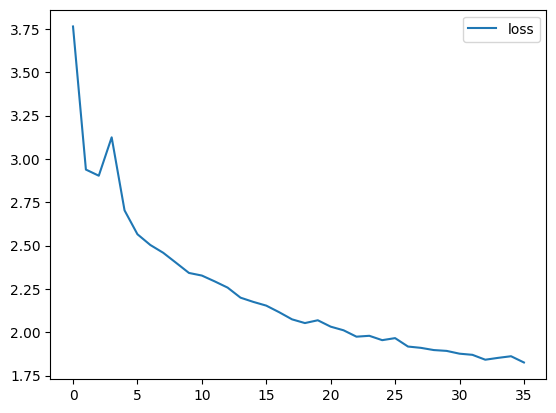

  8%|▊         | 4/50 [00:10<02:05,  2.74s/it]


KeyboardInterrupt: 

In [ ]:
from tqdm import tqdm
n_subseq = 100
l_subseq = 200
n_batches = len(text) // (n_subseq*l_subseq)
epochs = 50
for _ in tqdm(range(epochs)):
    for i in range(n_batches):
        batch_ix = generate_batch(text, n_subseq, l_subseq)
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
        # print(f'batch_ix = {batch_ix.shape}')
        logit_seq, _ = model(batch_ix, model.initial_state(n_subseq))

        # print(type(logp_seq))
        predictions_probs = logit_seq[:, :-1, :]
        actual_next_tokens = batch_ix[:, 1:]


        loss = criterion(logit_seq[:, :-1, :].reshape(-1, num_tokens), actual_next_tokens.reshape(-1))
        loss.backward()
        opt.step()

        opt.zero_grad()

        history.append(loss.data.numpy())

    clear_output(True)
    plt.plot(history,label='loss')
    plt.legend()
    plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [ ]:
def generate_text(char_rnn, seed_phrase='die', max_length=100, temperature=1.0):
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)

    out, hidden = char_rnn(x_sequence, hid_state)

    most_likely = torch.argmax(out, dim=-1)
    next_char = idx_to_token[most_likely[0][-1].item()]
    seed_phrase += next_char
    for _ in range(max_length - len(seed_phrase)):
        out, hidden = char_rnn(most_likely, hidden)
        most_likely = torch.argmax(out, dim=-1)
        next_char = idx_to_token[most_likely[0][-1].item()]
        seed_phrase += next_char
    return seed_phrase


In [ ]:
# An example of generated text.
print(generate_text(model, seed_phrase='die', max_length=200))

diedes tharen thangenit t thy pp tyonon there torey tow th bat  thar tt tt dinoouprn te tedeldeneve th tor there torey tow th bat  thar tt tt dinoouprn te tedeldeneve th tor there torey tow th bat  th


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [ ]:
class LSTM(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=128, rnn_num_units=128, num_layers=2):
        super(self.__class__, self).__init__()
        self.num_layers = num_layers
        self.emb_size = emb_size
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.lstm = nn.LSTM(emb_size, rnn_num_units, num_layers, batch_first=True)
        self.hid_to_logits = nn.Linear(emb_size, num_tokens)

    def forward(self, x, hidden):
        assert isinstance(x.data, torch.LongTensor)
        out, h_seq = self.lstm(self.emb(x), hidden)
        out = self.hid_to_logits(out)
        # print(out.shape, h_seq.shape)
        return out, h_seq
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return (torch.zeros(self.num_layers, batch_size, self.emb_size, requires_grad=True), torch.zeros(self.num_layers, batch_size, self.emb_size, requires_grad=True))

In [ ]:
model = LSTM()
lr=0.01
opt = torch.optim.AdamW(model.parameters(), lr=lr)
history = []
criterion = nn.CrossEntropyLoss()

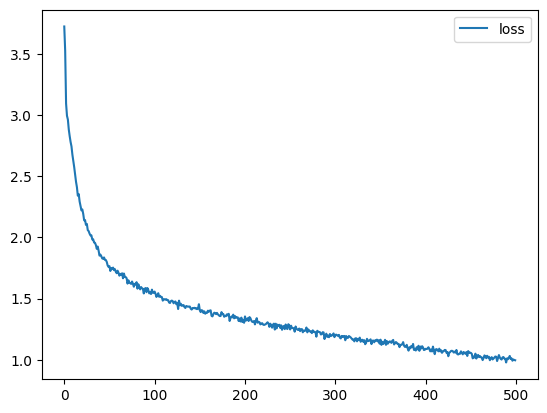

100%|██████████| 50/50 [05:25<00:00,  6.51s/it]


In [ ]:
n_subseq = 50
l_subseq = 200
n_batches = len(text) // (n_subseq*l_subseq)
epochs = 50
for _ in tqdm(range(epochs)):
    for i in range(n_batches):
        batch_ix = generate_batch(text, n_subseq, l_subseq)
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
        # print(f'batch_ix = {batch_ix.shape}')
        logit_seq, _ = model(batch_ix, model.initial_state(n_subseq))

        # print(type(logp_seq))
        predictions_probs = logit_seq[:, :-1, :]
        actual_next_tokens = batch_ix[:, 1:]


        loss = criterion(logit_seq[:, :-1, :].reshape(-1, num_tokens), actual_next_tokens.reshape(-1))
        loss.backward()
        opt.step()

        opt.zero_grad()

        history.append(loss.data.numpy())

    clear_output(True)
    plt.plot(history,label='loss')
    plt.legend()
    plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
def generate_sample(model, seed_phrase=' ', max_length=100, temperature=0.2):
    model.eval()
    h, c = model.initial_state(1)
    for i in range(0, max_length):
        x = torch.tensor([[token_to_idx[c] for c in seed_phrase[i:]]])
        y_pred, (h, c) = model(x, (h, c))
        last_char_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_char_logits / temperature, dim=0).detach().numpy()
        char_index = np.random.choice(len(last_char_logits), p=p)
        seed_phrase = seed_phrase + idx_to_token[char_index]
    return seed_phrase



In [ ]:
print(generate_sample(model, seed_phrase='when in disgrace', max_length=1000, temperature=0.5))

when in disgrace to store:
    permination be;
    if thou not such cross'd;
  and all the rose.

  lxxiii

  when i forbid of your more than to the cold?
    o! never with thee,
  thought i pray the content,
  that my soul doth stay,
    that is i forgoth
  to thee i love's rich of thee.

  xxix

  how can i will made of the pay.

  lxxxiii

  what with the part:
    you shall outlive thee,
    and they see i dost hide,
    but make the rest:
  but which i compare,
  and in thy heart.

  lxxxiii

  whilst thou ward.

  lxxxiii

  o! what a this pride.
    for nothing live,
  that mare that which good content,
  while me than thy sins all then like a jewel;
  so it be touches state.
    then hath my love,
  and on thy praise,
  while thou art in these despise,
  which i compare,
    that he i may,
  to living that heart,
  and by the prize.
    so i conseit best,
  as fair the shape;
  then by advance have,
  the cause of love,
  and your sweet self devise.

  xxix

  my sin, and there

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)